In [305]:
from pdf2image import convert_from_path
import PyPDF2
import os
import shutil
import pandas as pd
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from kneed import KneeLocator
import time
from sklearn.metrics import adjusted_rand_score

In [288]:
PATH = "./banks/"
IMAGE_PATH = "./images/"

In [289]:
try:
    os.mkdir('./images')
except:
    shutil.rmtree('./images')
    os.mkdir('./images')

for dir in os.listdir(PATH):
    inputpath = PATH+dir
    pdfFileObj = open(inputpath, 'rb')
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    numpages = pdfReader.numPages
    for i in range(1,numpages+1):
        pages = convert_from_path(inputpath, first_page=i, last_page=i+1)
        pages[0].save('./images/'+str(i)+'.jpg', 'JPEG')
print("PDF to Image conversion complete")  

PDF to Image conversion complete


In [290]:
resnet= tf.keras.applications.ResNet50(
      include_top=False,
      weights="imagenet",
      input_tensor=None,
      input_shape=(520,520,3),
      pooling=None)
inp = resnet.layers[0].input
out = tf.keras.layers.Flatten()(resnet.output)
modelr = tf.keras.Model(inputs=inp, outputs=out)

In [291]:
start_time = time.time()

df = []
names = []
for image in os.listdir(IMAGE_PATH):
    names.append(image.split('.')[0])
    img = cv2.imread(IMAGE_PATH+image)
    img = cv2.resize(img, (520,520))
    embeddings = modelr.predict(img[tf.newaxis,...])
    df.append(embeddings[0].tolist())
print("embeddings shape --> ", np.shape(df))
print("--- %s seconds ---" % (time.time() - start_time))

embeddings shape -->  (538, 591872)
--- 82.34675550460815 seconds ---


In [292]:
################## Feature Scaling #########################

scaler = MinMaxScaler()
df = scaler.fit_transform(df)
print("Scaling Done")
print("--- %s seconds ---" % (time.time() - start_time))

Scaling Done
--- 130.6787130832672 seconds ---


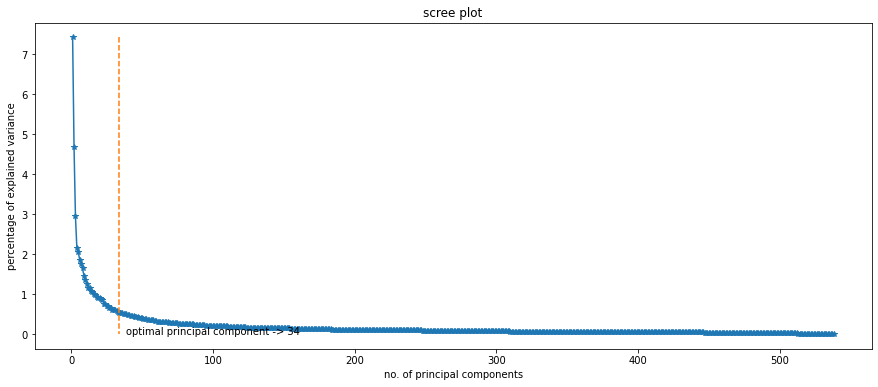

--- 193.94474148750305 seconds ---


In [293]:
################## Selecting optimal no. of Pricipal components ###################

pca = PCA()
pca_data = pca.fit_transform(np.array(df))
per_var = np.round(pca.explained_variance_ratio_*100, decimals=2)
lables = range(1, len(per_var)+1)
plt.figure(figsize=(15,6))
plt.xlabel('no. of principal components')
plt.ylabel('percentage of explained variance')
plt.title('scree plot')
plt.plot(lables, per_var, '-*')
kl = KneeLocator(lables, per_var, curve="convex", direction="decreasing")
plt.plot(np.full(len(per_var),kl.elbow).tolist(), per_var, '--')
plt.annotate('optimal principal component -> '+str(kl.elbow), (kl.elbow+5, 0))
plt.savefig('./scree_plot.png', dpi=500)
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

In [294]:
print("Optimal PCA component --> ", kl.elbow)
pca = PCA(kl.elbow)
#pca = PCA(3)
df = pca.fit_transform(np.array(df))
print("PCA component shape --> ", np.shape(df))
print("--- %s seconds ---" % (time.time() - start_time))

Optimal PCA component -->  34
PCA component shape -->  (538, 34)
--- 220.85121750831604 seconds ---


In [295]:
######### Giving page no. as a feature and normalinzing it with total no. of pages ####################### 

data = []
for i,embeds in enumerate(df):
    embed = embeds.tolist()
    embed.append(float((i+1)//len(df)))
    data.append(embed)

In [296]:
##################### Selecting optimal no. of clusters using WCSS #######################

#score = []
#neg_silhouette_samples = []
df = data
inertia = []
K = range(2,len(names)//2)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++')
    km = km.fit(df)
    #silhouette = silhouette_score(df, km.labels_, metric='euclidean')
    #score.append(silhouette)
    #sample_silhouette_values = silhouette_samples(df, km.labels_)
    #neg_silhouette_samples.append(len(np.extract(sample_silhouette_values<0, sample_silhouette_values)))
    inertia.append(km.inertia_)
print("--- %s seconds ---" % (time.time() - start_time))

--- 531.5042448043823 seconds ---


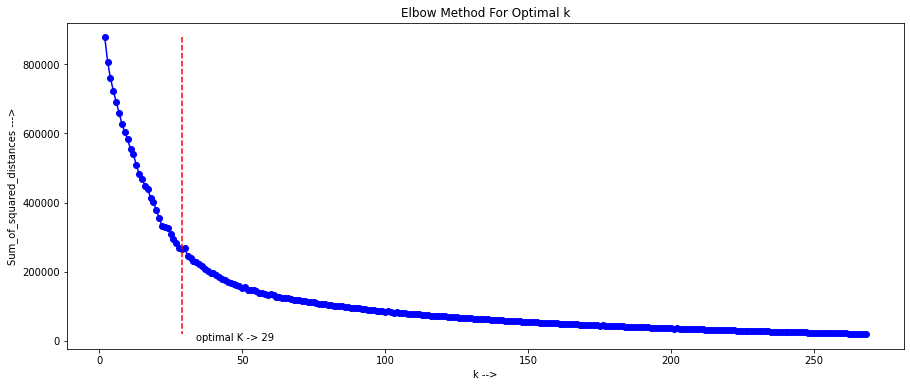

WCSS plot generated
--- 572.560469865799 seconds ---


In [297]:
kl = KneeLocator(K, inertia, curve="convex", direction="decreasing")
plt.figure(figsize=(15,6))
plt.xlabel('k -->')
plt.ylabel('Sum_of_squared_distances --->')
plt.title('Elbow Method For Optimal k')
plt.plot(K, inertia, 'bo-')
plt.plot(np.full(len(inertia),kl.elbow).tolist(), inertia, 'r--')
plt.annotate('optimal K -> '+str(kl.elbow), (kl.elbow+5, 0))
plt.savefig('./wcss_plot.png', dpi=500)
plt.show()
print("WCSS plot generated")
print("--- %s seconds ---" % (time.time() - start_time))

In [12]:
'''plt.figure(figsize=(15,6))
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('silhouette_plot')
plt.plot(K, score, 'go-')
plt.plot(K,np.full(len(K),max(score)), 'r--')
plt.plot(np.full(len(K),K[np.argmax(score)]), score,  'r--')
plt.annotate('optimal K -> '+str(K[np.argmax(score)]), (K[np.argmax(score)]-5, max(score)+0.005))
plt.savefig('./silhouette_plot.png', dpi=500)
plt.show()'''

"plt.figure(figsize=(15,6))\nplt.xlabel('k')\nplt.ylabel('silhouette_score')\nplt.title('silhouette_plot')\nplt.plot(K, score, 'go-')\nplt.plot(K,np.full(len(K),max(score)), 'r--')\nplt.plot(np.full(len(K),K[np.argmax(score)]), score,  'r--')\nplt.annotate('optimal K -> '+str(K[np.argmax(score)]), (K[np.argmax(score)]-5, max(score)+0.005))\nplt.savefig('./silhouette_plot.png', dpi=500)\nplt.show()"

In [299]:
################## clustering using optimal K values ################################

match = pd.DataFrame(columns=['name', 'labels'])
#km = KMeans(n_clusters=K[np.argmax(score)], init='k-means++', random_state=10)
km = KMeans(n_clusters=kl.elbow, init='k-means++', random_state=10)
km = km.fit(df)
match['labels'] = km.labels_.tolist()
match['name'] = names
match.head()

,name,labels
0,227,0
1,499,7
2,130,2
3,210,5
4,181,1


In [300]:
match.name = pd.to_numeric(match['name'])
match.labels = pd.to_numeric(match['labels'])
pages = []
for i in np.sort(match.labels.unique()):
    pages.append(list(np.sort(match['name'][match.labels == i].values)))
pagelabels = pd.DataFrame(columns=['groups'])
pagelabels['groups'] = pages

In [301]:
newgroups = []
thresh = 3
for group in pagelabels.groups:
    diff = []
    for i in range(len(group)-1):
        diff.append(group[i+1]-group[i])
    temp = []
    flag = 0
    sequenceflag = 0
    for index,i in enumerate(diff):
        if i==1:
            temp.append(group[index])
            flag=1
            sequenceflag = 1
        else:
            if i<thresh:
                temp.append(group[index])
                flag=1
                sequenceflag = 1
                for j in range(1,i):
                    temp.append(group[index]+j)
            else:
                if(sequenceflag==1):
                    temp.append(group[index])
                    sequenceflag=0
        if((index == len(diff)-1)&(diff[len(diff)-1]<thresh)):
            temp.append(group[len(diff)])
    
    if flag==1:
        clusters = []
        start=0
        for index, no in enumerate(temp):
            if(index<len(temp)-1):
                if((temp[index+1]-no)!=1):
                    clusters.append(temp[start:index+1])  
                    start = index+1
            if index==len(temp)-1:
                clusters.append(temp[start:index+1])
        newgroups.append(clusters)

In [302]:
i=0
while(i<len(newgroups)):
    #print(i)
    flag=0
    groups=newgroups[i]
    if i<len(newgroups)-1:
        for k,group in enumerate(groups):
            for j in range(i+1,len(newgroups)):
                comparegroups = newgroups[j]
                temp = []
                for l,comparegroup in enumerate(comparegroups):
                    if(len(set(group)&set(comparegroup))>0):
                        temp.append(list(set((group+comparegroup))))
                        newgroups[i][k].clear()
                        newgroups[j][l].clear()
                        flag=1
                        break
                if flag==1:
                    break
            if flag==1:
                i=0
                temp = np.sort(np.array(temp))
                newgroups = newgroups+temp[:,np.newaxis].tolist()
                break
    if flag!=1:
        i=i+1

clusters = []                        
for groups in newgroups:
    temp = []
    for group in groups:
        if len(group)!=0:
            temp.append(group)
    if len(temp)!=0:
        clusters.append(temp)

In [303]:
finalclusters = pd.DataFrame(columns=['groups'])
finalclusters.groups = clusters
finalclusters

,groups
0,"[[5, 6, 7], [10, 11, 12, 13, 14], [17, 18, 19,..."
1,"[[354, 355], [481, 482, 483, 484, 485, 486, 48..."
2,"[[31, 32], [49, 50], [86, 87, 88, 89], [101, 1..."
3,"[[105, 106, 107, 108, 109], [195, 196, 197, 19..."
4,"[[3, 4], [8, 9], [35, 36], [245, 246, 247, 248..."
5,"[[236, 237, 238, 239, 240, 241], [294, 295, 29..."
6,"[[283, 284, 285, 286, 287, 288, 289, 290, 291,..."
7,"[[67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, ..."
8,"[[15, 16], [136, 137, 138, 139, 140], [154, 15..."
9,"[[399, 400, 401, 402, 403, 404, 405, 406, 407,..."


In [304]:
for i,groups in enumerate(clusters):
    if i<len(clusters)-1:
        for k,group in enumerate(groups):
            for j in range(i+1,len(clusters)):
                comparegroups = clusters[j]
                for l,comparegroup in enumerate(comparegroups):
                    if(len(set(group)&set(comparegroup))>0):
                        print(True)
                        print(i,' ',k,'--',j,' ',l)
                        print(group,'---', comparegroup)

In [286]:
adjusted_rand_score([0,0,0,1,1,1],[2,2,2,0,0,0])

1.0

In [272]:
finalclusters.groups[1]

[[406, 407, 408, 409, 410, 411, 412, 413, 414],
 [600, 601, 602],
 [606, 607, 608],
 [612, 613, 614],
 [618, 619, 620]]

In [262]:
try:
    os.mkdir('./classes')
except:
    shutil.rmtree('./classes')
    os.mkdir('./classes')

for i in match['labels'].unique():
    os.makedirs('./classes/'+str(i))

for index,row in match.iterrows():
    shutil.copy(IMAGE_PATH+str(row['name'])+'.jpg', './classes/'+str(row['labels']))

In [175]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 669.6166045665741 seconds ---
